In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import os

from torch import nn, optim
from torch.optim import lr_scheduler
import time
import SOM

In [2]:
def sigma68(data): return 0.5*(pd.Series(data).quantile(q = 0.84) - pd.Series(data).quantile(q = 0.16))

In [3]:
def exposure_SN(cat_in, filters,  scale = True):

    sn_lims =  {'U': 25.25, 'G': 24.65, 'R': 24.15, 'I': 24.35, 'ZN': 23.95,  'H':25,'J':25, 'Y':25}

    scale_filters = [x for x in filters if scale == True]
    lims = [sn_lims[x] for x in filters]

    sn_val0 = 5
    R = 1

    sn_val = [(R*sn_val0 if x in scale_filters else sn_val0) for x in filters]

    D = sn_val*10**(np.array(lims) / 5.)

    mag = np.array(cat_in[[x for x in filters]])
    SN_arr =  D*10**(-0.2*mag)


    sn_min = 0
    sn_max = lims


    SN_arr = np.clip(SN_arr, sn_min, sn_max)
    SN = pd.DataFrame(SN_arr, columns=filters, index= cat_in.index)

    return SN



In [240]:
catalog = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/PAUS_mock_Euclidbands.csv', sep = ',', header = 0, comment = '#')
catalog = catalog.sample(40000)
catalog = catalog.dropna()

catalog['ref_id'] = np.arange(len(catalog))

nb_names_old = ['flux_nl_el_t_pau_nb%s'%x for x in 455+10*np.arange(40)]
nb_names_new = ['NB%s'%x for x in 455+10*np.arange(40)]
nb_name_dict = dict(zip(nb_names_old, nb_names_new))

catalog_nb_nl = catalog.set_index('ref_id')[nb_names_old].rename(columns = nb_name_dict)

bb_names_old = ['flux_nl_el_t_cfht_u','flux_nl_el_t_blanco_decam_g','flux_nl_el_t_blanco_decam_r','flux_nl_el_t_blanco_decam_i','flux_nl_el_t_blanco_decam_z','flux_nl_el_t_euclid_nisp_h','flux_nl_el_t_euclid_nisp_j','flux_nl_el_t_euclid_nisp_y']
bb_names_new = ['U','G','R','I','ZN','H','J','Y']
bb_name_dict = dict(zip(bb_names_old, bb_names_new))

catalog_bb_nl = catalog.set_index('ref_id')[bb_names_old].rename(columns = bb_name_dict)


In [241]:
# load fits from Martin Eriksen to estimate SNR from the flux

snr_fit = pd.read_csv('/nfs/pic.es/user/l/lcabayol/Euclid/snr_fit.csv', sep = ',', header = 0)
factors = snr_fit[snr_fit.key == 'med'].reset_index()

aas = factors.a.values
bs = factors.b.values

f = 0.7
SNR_NB = np.exp(aas*np.log(f*np.abs(catalog_nb_nl.values)) + bs)
err = (np.abs(catalog_nb_nl.values) / SNR_NB)  * np.random.normal(0,1, size = (catalog_nb_nl.shape))

catalog_nb = pd.DataFrame(catalog_nb_nl + err, columns = nb_names_new, index = catalog_nb_nl.index)
catalog_nb_err = pd.DataFrame(np.abs(err), columns = nb_names_new, index = catalog_nb_nl.index)

In [242]:
catalog_bb_nl_mag = 26 - 2.5*np.log10(catalog_bb_nl)
filters = bb_names_new.copy()

SNR_flagship_BB = exposure_SN(catalog_bb_nl_mag, filters,  scale = True)

err = np.abs(catalog_bb_nl / SNR_flagship_BB)
err_rand = err * np.random.normal(0,1, size = (err.shape))

catalog_bb = catalog_bb_nl.values + err_rand
catalog_bb_err = np.abs(err_rand)

catalog_bb = pd.DataFrame(catalog_bb, columns = bb_names_new, index = catalog_bb_nl.index)
catalog_bb_err = pd.DataFrame(np.abs(err), columns = bb_names_new, index = catalog_bb_nl.index)


In [243]:
catalog_bb = 26 - 2.5*np.log10(catalog_bb)
catalog_bb['target_zs'] = catalog.observed_redshift_gal.values
m = np.arange(18,24,1)
s68 = [0.0025,0.003,0.004,0.0045,0.0055,0.007]
fSNR  = np.polyfit(m,s68,2)
imag = catalog_bb.I.values
catalog_bb['true_z'] = catalog_bb.target_zs

In [244]:
zspec = catalog_bb.target_zs
outlier_frac= 0
x = np.ones(shape = len(zspec))

mask = np.random.choice(a = [0,1],p = [1-outlier_frac,outlier_frac],size=len(zspec)).astype(np.bool)
r_out = 0.76 * (1 + zspec) - 1
x[mask] = r_out[mask]
zspec = np.array([x[k] if x[k]!= 1 else zspec[k] for k in range(len(x))])

/tmp/ipykernel_22452/199062777.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.random.choice(a = [0,1],p = [1-outlier_frac,outlier_frac],size=len(zspec)).astype(np.bool)


In [245]:
dispersion_z = fSNR[0] * imag**2 + fSNR[1]*imag  + fSNR[2]
photoz = catalog_bb.target_zs.values+  dispersion_z * np.random.normal(0,1,size = catalog_bb.shape[0])

outlier_frac= 0
x = np.ones(shape = len(zspec))

mask = np.random.choice(a = [0,1],p = [1-outlier_frac,outlier_frac],size=len(zspec)).astype(np.bool)
r_out = 0.76 * (1 + zspec) - 1
x[mask] = r_out[mask]
photoz = np.array([x[k] if x[k]!= 1 else photoz[k] for k in range(len(x))])

/tmp/ipykernel_22452/2673824128.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.random.choice(a = [0,1],p = [1-outlier_frac,outlier_frac],size=len(zspec)).astype(np.bool)


In [246]:
catalog_bb['target_zb'] = photoz

#catalog_bb['target_train'] = catalog_bb.target_zs
mask_train = np.random.choice([0,1], p = [0.7,0.3], size = len(catalog_bb))
target_train = catalog_bb.target_zs * mask_train
target_train = np.where(target_train== 0,catalog_bb.target_zb,catalog_bb.target_zs)
catalog_bb['target_zs'] = catalog_bb.target_zs * mask_train
catalog_bb['target_zb'] = target_train


In [247]:
catalog_bb[catalog_bb.target_zs!= 0]

,U,G,R,I,ZN,H,J,Y,target_zs,true_z,target_zb
ref_id,,,,,,,,,,,
0,24.453787,24.266072,23.496436,22.844746,22.515142,22.101528,22.303939,22.468721,0.707375,0.707375,0.707375
1,23.564270,23.148758,22.283489,22.368190,22.343830,22.001850,21.888334,22.107320,0.428255,0.428255,0.428255
3,23.284542,23.073158,22.611966,21.658613,21.353623,20.762072,20.926112,21.289977,0.857867,0.857867,0.857867
8,25.120959,23.996824,22.578238,21.754079,21.251367,20.120398,20.429930,20.877939,0.663606,0.663606,0.663606
9,26.510566,26.865142,23.828461,22.710196,22.074548,20.423289,21.001167,21.563429,0.706241,0.706241,0.706241
...,...,...,...,...,...,...,...,...,...,...,...
39982,25.737840,25.517626,24.150879,22.968285,22.532971,20.821375,21.362548,21.794479,0.875953,0.875953,0.875953
39987,22.540322,21.716002,20.292298,19.682839,19.400403,18.400618,18.752977,19.124219,0.483216,0.483216,0.483216
39988,23.866879,23.965799,23.659429,22.991207,22.536808,22.214581,22.430241,22.693982,0.771958,0.771958,0.771958


In [248]:
import MTLphotozs

In [249]:
catalog_bb = catalog_bb.dropna()

### BB

In [250]:
catalog_bb_sub = catalog_bb[catalog_bb.target_zs != 0]#.reset_index()
catalog_nb_sub = catalog_nb[catalog_nb.index.isin(catalog_bb_sub.index)]
catalog_nb_sub = 26-2.5*np.log10(catalog_nb_sub)

In [251]:
BB = MTLphotozs.mtl_photoz(zs = True, flagship=True)
catalog_training= catalog_bb_sub.copy()
catalog_nb_train = catalog_nb_sub[catalog_nb_sub.index.isin(catalog_training.index)]

training_loader = BB.create_loader(catalog_training,catalog_nb_train)
BBnet = BB.train_mtl(training_loader, epochs = 65)

### BB+ NB



In [252]:
catalog_bb_sub = catalog_bb[catalog_bb.target_zb != 0].reset_index()
catalog_nb_sub = catalog_nb[catalog_nb.index.isin(catalog_bb_sub.index)]
catalog_nb_sub = 26-2.5*np.log10(catalog_nb_sub)

In [253]:
BBNB = MTLphotozs.mtl_photoz(zs = False, zs_NB = True, flagship = True)
catalog_training= catalog_bb_sub.copy()
catalog_nb_train = catalog_nb_sub[catalog_nb_sub.index.isin(catalog_training.index)]

training_loader = BBNB.create_loader(catalog_training,catalog_nb_train)
BBNBnet = BBNB.train_mtl(training_loader, epochs = 65)

### BB + z

In [254]:
catalog_bb_sub = catalog_bb[catalog_bb.target_zb != 0].reset_index()
catalog_nb_sub = catalog_nb[catalog_nb.index.isin(catalog_bb_sub.index)]
catalog_nb_sub = 26-2.5*np.log10(catalog_nb_sub)

In [255]:
BBz = MTLphotozs.mtl_photoz(zs = False, zs_zb = True, flagship = True)
catalog_training= catalog_bb_sub.copy()
catalog_nb_train = catalog_nb_sub[catalog_nb_sub.index.isin(catalog_training.index)]

training_loader = BBz.create_loader(catalog_training,catalog_nb_train)
BBznet = BBz.train_mtl(training_loader, epochs = 65)

### BB + NB +z

In [256]:
catalog_bb_sub = catalog_bb[catalog_bb.target_zb != 0].reset_index()
catalog_nb_sub = catalog_nb[catalog_nb.index.isin(catalog_bb_sub.index)]
catalog_nb_sub = 26-2.5*np.log10(catalog_nb_sub)

In [257]:
BBNBz = MTLphotozs.mtl_photoz(zs = False, zs_NB_zb = True, flagship = True)
catalog_training= catalog_bb_sub.copy()
catalog_nb_train = catalog_nb_sub[catalog_nb_sub.index.isin(catalog_training.index)]

training_loader = BBNBz.create_loader(catalog_training,catalog_nb_train)
BBNBznet = BBNBz.train_mtl(training_loader, epochs = 65)

## TEST TO i<25

In [258]:
catalog_test = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/Euclid_mock_v2.csv', sep = ',', header = 0, comment = '#')
catalog_test = catalog_test.dropna()
catalog_test = catalog_test[catalog_test.observed_redshift_gal < 1.5]

catalog_test['mag'] =  -2.5 * np.log10(catalog_test.blanco_decam_i) - 48.6
catalog_test = catalog_test[catalog_test.mag < 25]
catalog_test = catalog_test[catalog_test.mag > 18]
catalog_test = catalog_test.sample(50000)
catalog_test = catalog_test.reset_index()

In [259]:
BB_name = ['cfis_u','blanco_decam_g','blanco_decam_r','blanco_decam_i','blanco_decam_z','euclid_nisp_h','euclid_nisp_j','euclid_nisp_y']
catalog_bb_test = catalog_test[BB_name]
bb_names_new = ['U','G','R','I','ZN','H','J','Y']
bb_name_dict = dict(zip(BB_name, bb_names_new))

catalog_bb_test_nl = catalog_bb_test.rename(columns = bb_name_dict)
catalog_bb_test_nl_mag = -48.6 - 2.5*np.log10(catalog_bb_test_nl)
filters = bb_names_new.copy()

SNR_flagship_BB = exposure_SN(catalog_bb_test_nl_mag, filters,  scale = True)
err = np.abs(catalog_bb_test_nl / SNR_flagship_BB)
err_rand = err * np.random.normal(0,1, size = (err.shape))

catalog_bb_test = catalog_bb_test_nl.values + err_rand.values

catalog_bb_test = pd.DataFrame(catalog_bb_test, columns = bb_names_new)

samps_BB_spec_test_store = catalog_bb_test.copy()

samps_BB_spec_test = catalog_bb_test[bb_names_new].values
samps_BB_spec_test = -2.5 * np.log10(samps_BB_spec_test) - 48.6

zspec_test = catalog_test.observed_redshift_gal.values
zb_bin_spec_test = 1000* zspec_test

colors_spec_test = samps_BB_spec_test[:,:-1] - samps_BB_spec_test[:,1:] 

colors_spec_test, zspec_test, zb_bin_spec_test = torch.Tensor(colors_spec_test), torch.Tensor(zspec_test), torch.LongTensor(zb_bin_spec_test)
mag_test = -2.5 * np.log10(catalog_bb_test.I) - 48.6


/tmp/ipykernel_22452/2075870673.py:21: RuntimeWarning: invalid value encountered in log10
  samps_BB_spec_test = -2.5 * np.log10(samps_BB_spec_test) - 48.6


In [260]:
BBnet = BBnet.eval()
_, logalphas, z,logzerr = BBnet(colors_spec_test.cuda())
alphas = torch.exp(logalphas)
zb = (alphas * z).sum(1)
zb,logzerr  = zb.detach().cpu().numpy(), logzerr.detach().cpu().numpy()

df_bb = pd.DataFrame(np.c_[zb,zspec_test,mag_test], columns = ['zb_bb','zb_true','imag'])
df_bb['rerr_bb'] = (df_bb.zb_bb - df_bb.zb_true) / (1 + df_bb.zb_true)
print('Bias',np.nanmedian(df_bb.rerr_bb), 'scatter', sigma68(df_bb.rerr_bb))


Bias -0.028069026652270422 scatter 0.08364752025609591


In [261]:
BBNBnet = BBNBnet.eval()
_, logalphas, z,logzerr = BBNBnet(colors_spec_test.cuda()) 
alphas = torch.exp(logalphas)
zb = (alphas * z).sum(1)
zb,logzerr  = zb.detach().cpu().numpy(), logzerr.detach().cpu().numpy()

df_bbnb = pd.DataFrame(np.c_[zb,zspec_test,mag_test], columns = ['zb_bbnb','zb_true','imag'])
df_bbnb['rerr_bbnb'] = (df_bbnb.zb_bbnb - df_bbnb.zb_true) / (1 + df_bbnb.zb_true)
print('Bias',np.nanmedian(df_bbnb.rerr_bbnb), 'scatter', sigma68(df_bbnb.rerr_bbnb))


Bias -0.024123899414731618 scatter 0.08170021202318495


In [262]:
BBznet = BBznet.eval()
_, logalphas, z,logzerr = BBznet(colors_spec_test.cuda()) 
alphas = torch.exp(logalphas)
zb = (alphas * z).sum(1)
zb,logzerr  = zb.detach().cpu().numpy(), logzerr.detach().cpu().numpy()

df_bbz = pd.DataFrame(np.c_[zb,zspec_test,mag_test], columns = ['zb_bbz','zb_true','imag'])
df_bbz['rerr_bbz'] = (df_bbz.zb_bbz - df_bbz.zb_true) / (1 + df_bbz.zb_true)
print('Bias',np.nanmedian(df_bbz.rerr_bbz), 'scatter', sigma68(df_bbz.rerr_bbz))


Bias -0.019667139409442654 scatter 0.0776919070212781


In [263]:
BBNBznet = BBNBznet.eval()
_, logalphas, z,logzerr = BBNBznet(colors_spec_test.cuda()) 
alphas = torch.exp(logalphas)
zb = (alphas * z).sum(1)
zb,logzerr  = zb.detach().cpu().numpy(), logzerr.detach().cpu().numpy()

df_bbnbz = pd.DataFrame(np.c_[zb,zspec_test,mag_test], columns = ['zb_bbnbz','zb_true','imag'])
df_bbnbz['rerr_bbnbz'] = (df_bbnbz.zb_bbnbz - df_bbnbz.zb_true) / (1 + df_bbnbz.zb_true)
print('Bias',np.nanmedian(df_bbnbz.rerr_bbnbz), 'scatter', sigma68(df_bbnbz.rerr_bbnbz))


Bias -0.0236271935153254 scatter 0.07766097490939823


In [264]:
df = df_bb.reset_index().merge(df_bbnb[['zb_bbnb','rerr_bbnb']].reset_index(), on = 'index')
df = df.merge(df_bbz[['zb_bbz','rerr_bbz']].reset_index(), on = 'index')
df = df.merge(df_bbnbz[['zb_bbnbz','rerr_bbnbz']].reset_index(), on = 'index')

In [265]:
df_0_pc = df.copy()

# PLOTS

In [272]:
from scipy import stats

def stats_plots(dfplot):
    bin_edges = stats.mstats.mquantiles(dfplot.imag, np.arange(0.1,1.01,0.1))
    #bin_edges = np.arange(16,25.1,1)

    xlab, s68_bb, s68_bbnb, s68_bbz, s68_bbnbz = [],[],[],[], []
    outliers_bb, outliers_bbnb, outliers_bbz, outliers_bbnbz = [],[],[],[]
    bias_bb, bias_bbnb, bias_bbz, bias_bbnbz  = [],[], [],[]
    outliers_bb_cum, outliers_bbnb_cum, outliers_bbz_cum, outliers_bbnbz_cum = [],[],[],[]



    for k in range(len(bin_edges)-1):
        edge_min = bin_edges[k]
        edge_max = bin_edges[k+1]

        mean_mag =  (edge_max + edge_min) / 2

        df_bin = dfplot[(dfplot.imag > edge_min) & (dfplot.imag < edge_max)]
        df_bin_cum = dfplot[(dfplot.imag < edge_max)]


        xlab.append(mean_mag)
        s68_bb.append(sigma68(df_bin.rerr_bb))
        s68_bbnb.append(sigma68(df_bin.rerr_bbnb))
        s68_bbz.append(sigma68(df_bin.rerr_bbz))
        s68_bbnbz.append(sigma68(df_bin.rerr_bbnbz))


        bias_bb.append(np.nanmedian(df_bin.rerr_bb))
        bias_bbnb.append(np.nanmedian(df_bin.rerr_bbnb))
        bias_bbz.append(np.nanmedian(df_bin.rerr_bbz))
        bias_bbnbz.append(np.nanmedian(df_bin.rerr_bbnbz))



        outliers_bb.append(len(df_bin[np.abs(df_bin.rerr_bb)>0.15])/len(df_bin))
        outliers_bbnb.append(len(df_bin[np.abs(df_bin.rerr_bbnb)>0.15])/len(df_bin))
        outliers_bbz.append(len(df_bin[np.abs(df_bin.rerr_bbz)>0.15])/len(df_bin))
        outliers_bbnbz.append(len(df_bin[np.abs(df_bin.rerr_bbnbz)>0.15])/len(df_bin))

        outliers_bb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bb)>0.15])/len(df_bin_cum))
        outliers_bbnb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnb)>0.15])/len(df_bin_cum))
        outliers_bbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbz)>0.15])/len(df_bin_cum))
        outliers_bbnbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnbz)>0.15])/len(df_bin_cum))
        
        
    df_bias = pd.DataFrame(np.c_[xlab, bias_bb,bias_bbnb,bias_bbz,bias_bbnbz], columns = ['mag','bb','bbnb','bbz','bbnbz'])
    df_s68 = pd.DataFrame(np.c_[xlab, s68_bb,s68_bbnb,s68_bbz,s68_bbnbz], columns = ['mag','bb','bbnb','bbz','bbnbz'])
    df_outliers = pd.DataFrame(np.c_[xlab, outliers_bb,outliers_bbnb,outliers_bbz,outliers_bbnbz], columns = ['mag','bb','bbnb','bbz','bbnbz'])
    df_outlierscum = pd.DataFrame(np.c_[xlab, outliers_bb_cum,outliers_bbnb_cum,outliers_bbz_cum,outliers_bbnbz_cum], columns = ['mag','bb','bbnb','bbz','bbnbz'])

    return df_bias, df_s68, df_outliers, df_outlierscum


In [289]:
df_0 = df_0[df_0.imag < 25]
df_0pc = df_0pc[df_0pc.imag < 25]
df_1pc = df_1pc[df_1pc.imag < 25]
df_3pc = df_3pc[df_3pc.imag < 25]
df_5pc = df_5pc[df_5pc.imag < 25]
df_7pc = df_7pc[df_7pc.imag < 25]
df_10pc = df_10pc[df_10pc.imag < 25]
df_12pc = df_12pc[df_12pc.imag < 25]
df_15pc = df_15pc[df_15pc.imag < 25]

In [290]:
df_bias_0, df_s68_0, df_outliers_0, df_outlierscum_0 = stats_plots(df_0)
df_bias_0pc, df_s68_0pc, df_outliers_0pc, df_outlierscum_0pc = stats_plots(df_0pc)
df_bias_1pc, df_s68_1pc, df_outliers_1pc, df_outlierscum_1pc = stats_plots(df_1pc)
df_bias_3pc, df_s68_3pc, df_outliers_3pc, df_outlierscum_3pc = stats_plots(df_3pc)
df_bias_5pc, df_s68_5pc, df_outliers_5pc, df_outlierscum_5pc = stats_plots(df_5pc)
df_bias_7pc, df_s68_7pc, df_outliers_7pc, df_outlierscum_7pc = stats_plots(df_7pc)
df_bias_10pc, df_s68_10pc, df_outliers_10pc, df_outlierscum_10pc = stats_plots(df_10pc)
df_bias_12pc, df_s668_12pc, df_outliers_12pc, df_outlierscum_12pc = stats_plots(df_12pc)
df_bias_15pc, df_s68_15pc, df_outliers_15pc, df_outlierscum_15pc = stats_plots(df_15pc)

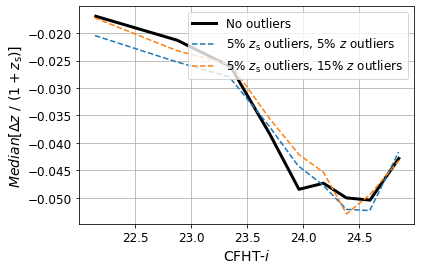

In [306]:
plt.plot(df_bias_0.mag.values,df_bias_0.bb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
plt.plot(df_bias_0pc.mag.values,df_bias_0pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z$ outliers')
#plt.plot(df_bias_1pc.mag.values,df_bias_1pc.bb.values, ls ='--')
#plt.plot(df_bias_3pc.mag.values,df_bias_3pc.bb.values, ls ='--')
#plt.plot(df_bias_5pc.mag.values,df_bias_5pc.bb.values, ls ='--')
#plt.plot(df_bias_7pc.mag.values,df_bias_7pc.bb.values, ls ='--')
#plt.plot(df_bias_10pc.mag.values,df_bias_10pc.bb.values, ls ='--')
#plt.plot(df_bias_12pc.mag.values,df_bias_12pc.bb.values, ls ='--')
plt.plot(df_bias_15pc.mag.values,df_bias_15pc.bb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 15% $z$ outliers')
plt.ylabel(r'$Median[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 14)
plt.xlabel(r'CFHT-$i$', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid()

plt.legend(fontsize = 12)

Text(0.5, 0, 'CFHT-$i$')

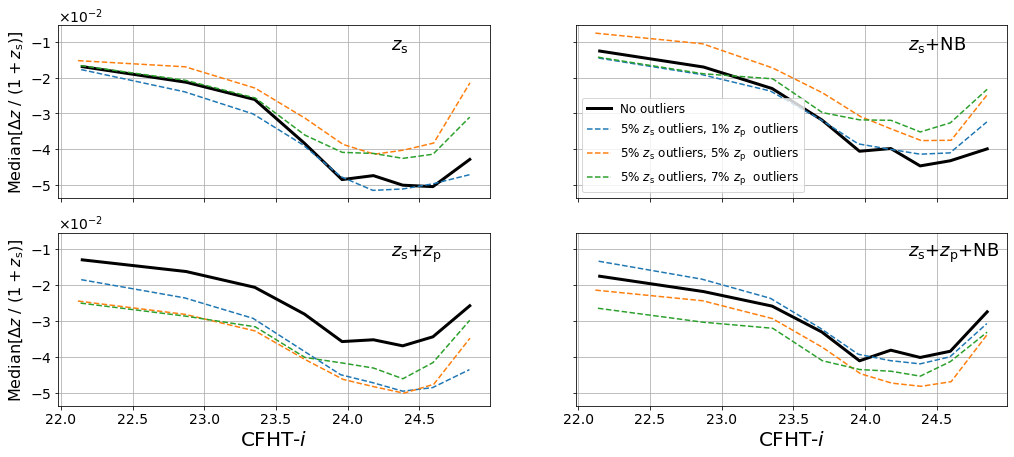

In [355]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7), sharey=True)
#st = fig.suptitle("Flagship2 sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(df_bias_0.mag.values,df_bias_0.bb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[0,0].plot(df_bias_0pc.mag.values,df_bias_1pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[0,0].plot(df_bias_7pc.mag.values,df_bias_5pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[0,0].plot(df_bias_15pc.mag.values,df_bias_7pc.bb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[0,1].plot(df_bias_0.mag.values,df_bias_0.bbnb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[0,1].plot(df_bias_0pc.mag.values,df_bias_1pc.bbnb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[0,1].plot(df_bias_7pc.mag.values,df_bias_5pc.bbnb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[0,1].plot(df_bias_15pc.mag.values,df_bias_7pc.bbnb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[1,0].plot(df_bias_0.mag.values,df_bias_0.bbz.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[1,0].plot(df_bias_0pc.mag.values,df_bias_1pc.bbz.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[1,0].plot(df_bias_7pc.mag.values,df_bias_5pc.bbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[1,0].plot(df_bias_15pc.mag.values,df_bias_7pc.bbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[1,1].plot(df_bias_0.mag.values,df_bias_0.bbnbz.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[1,1].plot(df_bias_0pc.mag.values,df_bias_1pc.bbnbz.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[1,1].plot(df_bias_7pc.mag.values,df_bias_5pc.bbnbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[1,1].plot(df_bias_15pc.mag.values,df_bias_7pc.bbnbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[0,0].text(24.3,-0.012,s=r'$z_{\rm s}$',fontsize = 18)
ax[0,1].text(24.3,-0.012,s=r'$z_{\rm s}$+NB',fontsize = 18)
ax[1,0].text(24.3,-0.012,s=r'$z_{\rm s}$+$z_{\rm p}$',fontsize = 18)
ax[1,1].text(24.3,-0.012,s=r'$z_{\rm s}$+$z_{\rm p}$+NB',fontsize = 18)


ax[0,1].legend(fontsize = 12)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'Median$[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,0].set_ylabel(r'Median$[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,1].set_xlabel(r'CFHT-$i$', fontsize = 20)
ax[1,0].set_xlabel(r'CFHT-$i$', fontsize = 20)



#plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/flagship_outliers_bias.pdf', bbox_inches = 'tight')


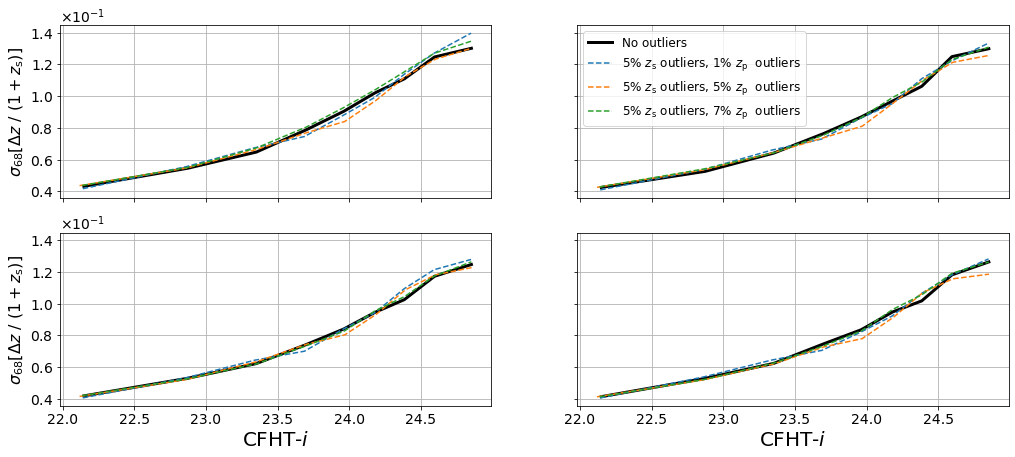

In [358]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7), sharey=True)
#st = fig.suptitle("Flagship2 sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 



ax[0,0].plot(df_bias_0.mag.values,df_s68_0.bb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[0,0].plot(df_bias_0pc.mag.values,df_s68_1pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[0,0].plot(df_bias_7pc.mag.values,df_s68_5pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[0,0].plot(df_bias_15pc.mag.values,df_s68_7pc.bb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[0,1].plot(df_bias_0.mag.values,df_s68_0.bbnb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[0,1].plot(df_bias_0pc.mag.values,df_s68_1pc.bbnb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[0,1].plot(df_bias_7pc.mag.values,df_s68_5pc.bbnb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[0,1].plot(df_bias_15pc.mag.values,df_s68_7pc.bbnb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[1,0].plot(df_bias_0.mag.values,df_s68_0.bbz.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[1,0].plot(df_bias_0pc.mag.values,df_s68_1pc.bbz.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[1,0].plot(df_bias_7pc.mag.values,df_s68_5pc.bbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[1,0].plot(df_bias_15pc.mag.values,df_s68_7pc.bbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[1,1].plot(df_bias_0.mag.values,df_s68_0.bbnbz.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[1,1].plot(df_bias_0pc.mag.values,df_s68_1pc.bbnbz.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[1,1].plot(df_bias_7pc.mag.values,df_s68_5pc.bbnbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[1,1].plot(df_bias_15pc.mag.values,df_s68_7pc.bbnbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[0,1].legend(fontsize = 12)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'$\sigma_{\rm 68}[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,0].set_ylabel(r'$\sigma_{\rm 68}[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,1].set_xlabel(r'CFHT-$i$', fontsize = 20)
ax[1,0].set_xlabel(r'CFHT-$i$', fontsize = 20)



plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/flagship_outliers_s68.pdf', bbox_inches = 'tight')


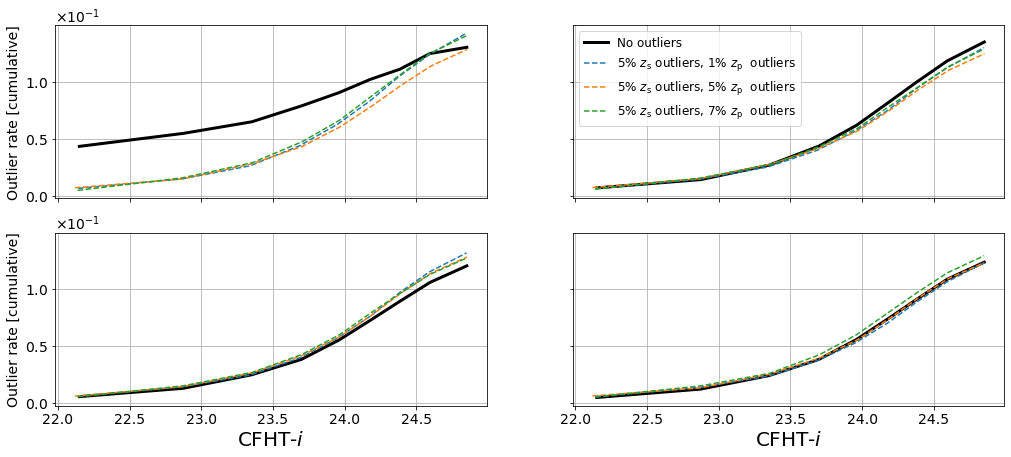

In [361]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7), sharey=True)
#st = fig.suptitle("Flagship2 sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(df_bias_0.mag.values,df_s68_0.bb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[0,0].plot(df_bias_0pc.mag.values,df_outlierscum_1pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[0,0].plot(df_bias_7pc.mag.values,df_outlierscum_5pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[0,0].plot(df_bias_15pc.mag.values,df_outlierscum_7pc.bb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[0,1].plot(df_bias_0.mag.values,df_outlierscum_0.bbnb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[0,1].plot(df_bias_0pc.mag.values,df_outlierscum_1pc.bbnb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[0,1].plot(df_bias_7pc.mag.values,df_outlierscum_5pc.bbnb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[0,1].plot(df_bias_15pc.mag.values,df_outlierscum_7pc.bbnb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[1,0].plot(df_bias_0.mag.values,df_outlierscum_0.bbz.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[1,0].plot(df_bias_0pc.mag.values,df_outlierscum_1pc.bbz.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[1,0].plot(df_bias_7pc.mag.values,df_outlierscum_5pc.bbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[1,0].plot(df_bias_15pc.mag.values,df_outlierscum_7pc.bbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[1,1].plot(df_bias_0.mag.values,df_outlierscum_0.bbnbz.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[1,1].plot(df_bias_0pc.mag.values,df_outlierscum_1pc.bbnbz.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[1,1].plot(df_bias_7pc.mag.values,df_outlierscum_5pc.bbnbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[1,1].plot(df_bias_15pc.mag.values,df_outlierscum_7pc.bbnbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')


ax[0,1].legend(fontsize = 12)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'Outlier rate [cumulative]', fontsize = 14)
ax[1,0].set_ylabel(r'Outlier rate [cumulative]', fontsize = 14)
ax[1,1].set_xlabel(r'CFHT-$i$', fontsize = 20)
ax[1,0].set_xlabel(r'CFHT-$i$', fontsize = 20)



plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/flagship_outliers_outlierscum.pdf', bbox_inches = 'tight')


In [321]:
df_s68_0pc

,mag,bb,bbnb,bbz,bbnbz
0,22.141408,0.043848,0.042825,0.040691,0.041023
1,22.861974,0.054623,0.052760,0.050675,0.051098
2,23.339454,0.065307,0.065474,0.061881,0.062671
3,23.686408,0.076325,0.073366,0.070974,0.071063
4,23.951428,0.087894,0.085846,0.080697,0.081644
5,24.175972,0.098947,0.096626,0.090837,0.092012
6,24.383953,0.110183,0.107572,0.103892,0.104247
7,24.591866,0.122365,0.122348,0.113716,0.118158
8,24.849122,0.125594,0.128735,0.120807,0.126690


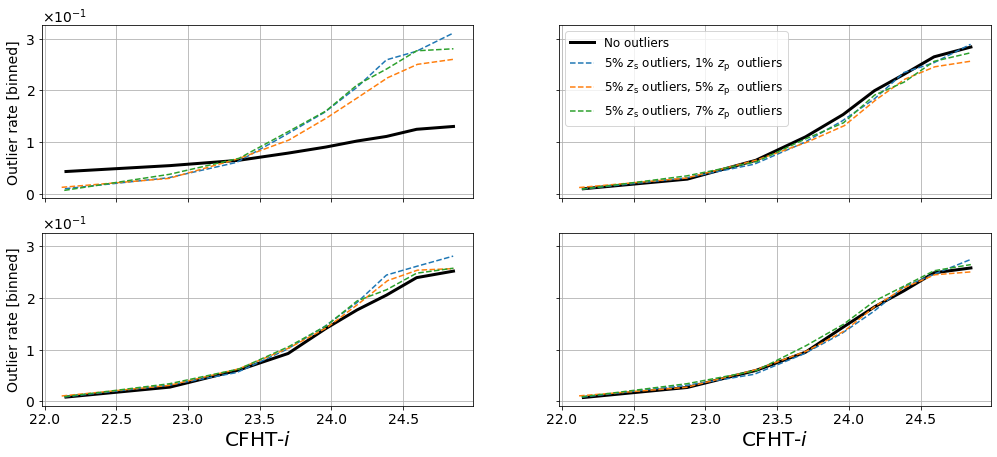

In [363]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7), sharey=True)
#st = fig.suptitle("Flagship2 sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(df_bias_0.mag.values,df_s68_0.bb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[0,0].plot(df_bias_0pc.mag.values,df_outliers_1pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[0,0].plot(df_bias_7pc.mag.values,df_outliers_5pc.bb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[0,0].plot(df_bias_15pc.mag.values,df_outliers_7pc.bb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[0,1].plot(df_bias_0.mag.values,df_outliers_0.bbnb.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[0,1].plot(df_bias_0pc.mag.values,df_outliers_1pc.bbnb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[0,1].plot(df_bias_7pc.mag.values,df_outliers_5pc.bbnb.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[0,1].plot(df_bias_15pc.mag.values,df_outliers_7pc.bbnb.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[1,0].plot(df_bias_0.mag.values,df_outliers_0.bbz.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[1,0].plot(df_bias_0pc.mag.values,df_outliers_1pc.bbz.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[1,0].plot(df_bias_7pc.mag.values,df_outliers_5pc.bbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[1,0].plot(df_bias_15pc.mag.values,df_outliers_7pc.bbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')

ax[1,1].plot(df_bias_0.mag.values,df_outliers_0.bbnbz.values, color = 'black', lw = 3, ls = '-', label = 'No outliers')
ax[1,1].plot(df_bias_0pc.mag.values,df_outliers_1pc.bbnbz.values, ls ='--', label = r'5% $z_{\rm s}$ outliers, 1% $z_{\rm p}$  outliers')
ax[1,1].plot(df_bias_7pc.mag.values,df_outliers_5pc.bbnbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 5% $z_{\rm p}$  outliers')
ax[1,1].plot(df_bias_15pc.mag.values,df_outliers_7pc.bbnbz.values, ls ='--',label = r'5% $z_{\rm s}$ outliers, 7% $z_{\rm p}$  outliers')


ax[0,1].legend(fontsize = 12)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'Outlier rate [binned]', fontsize = 14)
ax[1,0].set_ylabel(r'Outlier rate [binned]', fontsize = 14)
ax[1,1].set_xlabel(r'CFHT-$i$', fontsize = 20)
ax[1,0].set_xlabel(r'CFHT-$i$', fontsize = 20)



plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/flagship_outliers_outliersbinned.pdf', bbox_inches = 'tight')
